In [ ]:
# pip install opencv-python

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [33]:
def extract_orb_features(image_path):
    """
    Extracts ORB features from an image.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    # Initialize the ORB detector
    orb = cv2.ORB_create()
    # Find the keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("The image path is invalid.")

    # Initialize the AKAZE detector
    ORB = cv2.ORB_create()

    # Detect keypoints and descriptors with AKAZE
    kp, des = ORB.detectAndCompute(img, None)
    kp = kp[:100]
    len(kp)
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Image: {image_name(image_path)} Keypoints')
    plt.axis('off')
    plt.show()

def image_name(image_path):
    return os.path.splitext(os.path.basename(image_path))[0]


image1_path = 'nk_collection_meubels_cleaned/meubel_1.jpg'
image2_path = 'nk_collection_meubels_cleaned/meubel_2.jpg'

import pandas as pd

def get_table(sims):
    """
    This function takes the output produced by either the compute_similarities \ 
    or compute_similarities_testsets function, and returns a pandas dataframe/table \
    and also saves it in excel.
    """
    
    data = {}
    rows = []

    for key, value in sims.items():
        if key[0] not in data:
            data[key[0]] = []
        if key[1] not in rows:
            rows.append(key[1])
        data[key[0]].append(value)
        
    data = {key[:key.rfind(".")]:value for key, value in data.items()}
    rows = [row[:row.rfind(".")] for row in rows]
        
    df = pd.DataFrame(data, index=rows)
    #df.to_excel('output.xlsx')
    return df.T
    


<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
C:\Users\used\AppData\Local\Temp\ipykernel_19892\2547174886.py:33: SyntaxWarning: invalid escape sequence '\ '
  """


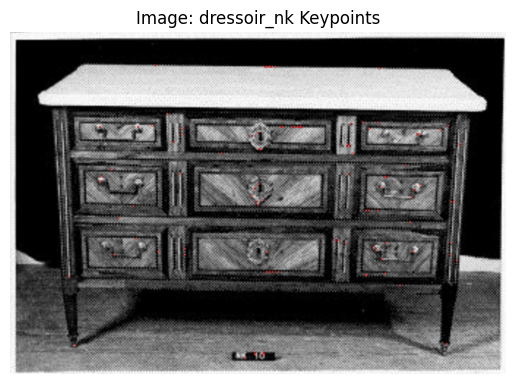

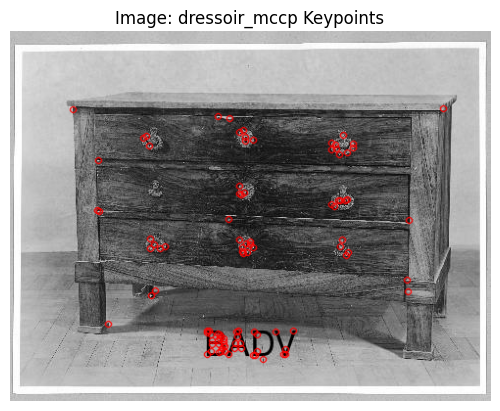

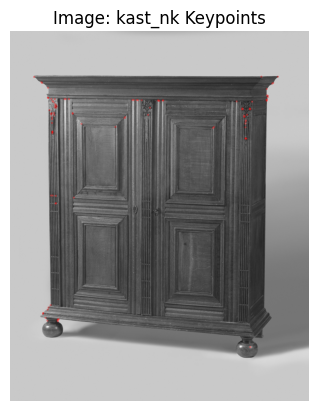

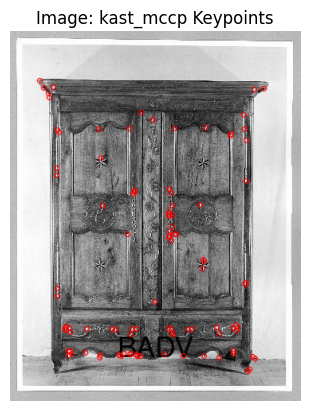

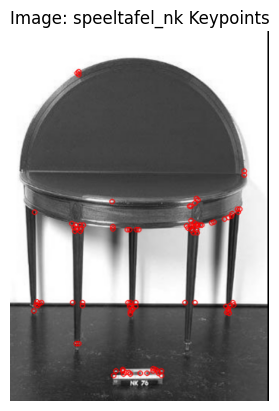

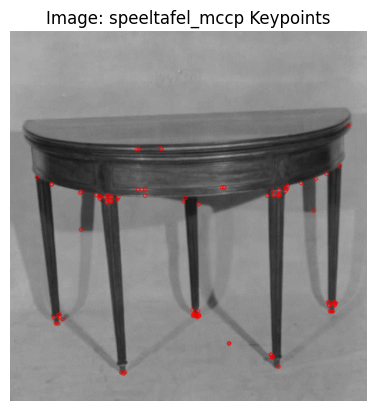

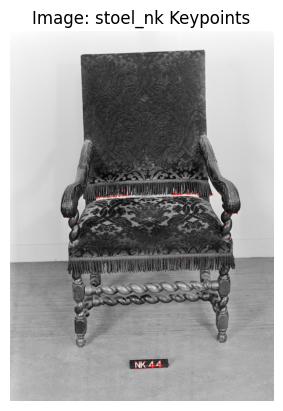

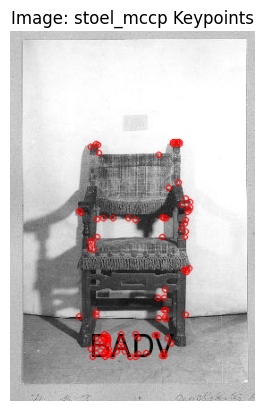

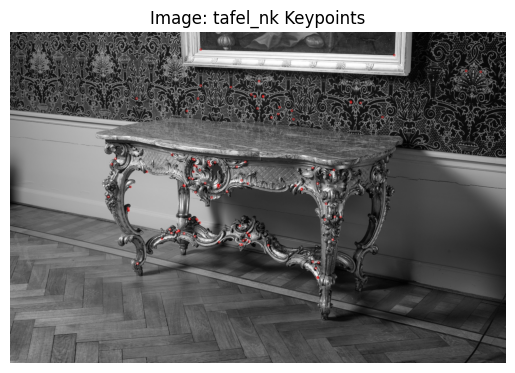

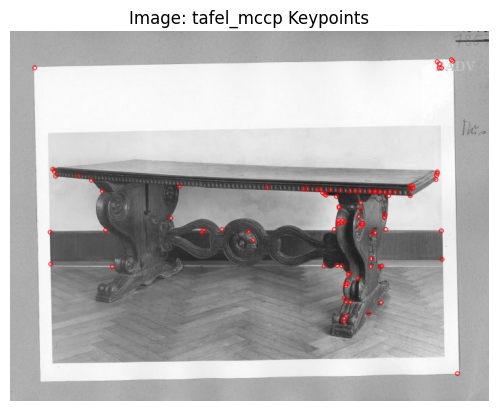

In [40]:
nk_index = 0
munich_index = 0
nk_path = "nk_testset"
munich_path = "munich_testset"
nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)


while nk_index < len(nk_testset) and munich_index < len(munich_testset):
    # Print from nk_testset
    nk_img = nk_testset[nk_index]
    nk_img_path = os.path.join(nk_path, nk_img)
    visualize_keypoints(nk_img_path)
    nk_index += 1
    
    # Check if we can print from munich_testset
    if munich_index < len(munich_testset):
        munich_img = munich_testset[munich_index]
        munich_img_path = os.path.join(munich_path, munich_img)
        visualize_keypoints(munich_img_path)
        munich_index += 1


# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

In [38]:
def compute_orb_similarity(des1, des2, kp1, kp2):
    """
    Computes similarity between two sets of ORB descriptors using BFMatcher and ratio test.
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    # Match descriptors with KNN
    matches = bf.knnMatch(des1, des2, k=2)
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 4:
        return 0.0  # Not enough matches to compute homography

    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Use RANSAC to find the best transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if mask is None:
        return 0.0  # If RANSAC fails to find a valid transformation

    # Calculate the number of inliers
    num_inliers = np.sum(mask)

    # Compute the similarity score based on the number of inliers
    similarity_score = num_inliers / len(good_matches)
    return similarity_score

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    This function takes four arguments: 
    - munich_testset, which contains grayscaled images from the Munich database.
    - nk_testset, which contains grayscaled images from the NK collection API.
    - munich path, the path to the directory of the Munich images. 
    - nk_path, the path to the directory of the NK images. 
    
    It then computes the ORB descriptors for the Munich images and all the
    NK collection images. Afterwards, it computes the similarity using ORB features.
    It then saves the similarity and the two images as key-value pairs in a dictionary.
    """
    
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_kp, nk_des = extract_orb_features(nk_img_path)
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_kp, munich_des = extract_orb_features(munich_img_path)
            except ValueError as e:
                print(e)
                continue
            similarity = compute_orb_similarity(nk_des, munich_des, nk_kp, munich_kp)
            similarities[(nk_img, munich_img)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
get_table(sims)


,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,0.0,0.833333,0.625,1.0,1.0
kast_nk,1.0,0.000000,0.000,0.0,0.0
speeltafel_nk,0.0,0.625000,0.500,0.0,0.0
stoel_nk,1.0,0.000000,0.000,0.0,0.0
tafel_nk,0.0,0.000000,0.000,1.0,0.0


In [28]:
import cv2
import os
import numpy as np

def compute_similarity(image1_path, image2_path):
    np.random.seed(42)
    # Load the images in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("One or both of the image paths are invalid.")

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    # print(matches[10:])
    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:100]]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:100]]).reshape(-1, 1, 2)

    # Use RANSAC to find the best transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 50,maxIters=10000)

    # Calculate the number of inliers
    num_inliers = np.sum(mask)

    # Compute the similarity score based on the number of inliers
    similarity_score = num_inliers / 100
    return similarity_score


def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    This function takes four arguments: 
    - munich_testset, which contains grayscaled images from the Munich database.
    - nk_testset, which contains grayscaled images from the NK collection API.
    - munich path, the path to the directory of the Munich images. 
    - nk_path, the path to the directory of the NK images. 
    
    It then computes the similarity using ORB features.
    It then saves the similarity and the two images as key-value pairs in a dictionary.
    """
    
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                similarity = compute_similarity(nk_img_path, munich_img_path)
                similarities[(nk_img, munich_img)] = similarity
            except ValueError as e:
                print(e)
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
print(sims)

get_table(sims)


{('dressoir_nk.jpg', 'dressoir_mccp.jpg'): 0.29, ('dressoir_nk.jpg', 'kast_mccp.jpg'): 0.23, ('dressoir_nk.jpg', 'speeltafel_mccp.png'): 0.29, ('dressoir_nk.jpg', 'stoel_mccp.jpg'): 0.45, ('dressoir_nk.jpg', 'tafel_mccp.jpg'): 0.45, ('kast_nk.jpg', 'dressoir_mccp.jpg'): 0.37, ('kast_nk.jpg', 'kast_mccp.jpg'): 0.28, ('kast_nk.jpg', 'speeltafel_mccp.png'): 0.33, ('kast_nk.jpg', 'stoel_mccp.jpg'): 0.59, ('kast_nk.jpg', 'tafel_mccp.jpg'): 0.3, ('speeltafel_nk.png', 'dressoir_mccp.jpg'): 0.29, ('speeltafel_nk.png', 'kast_mccp.jpg'): 0.26, ('speeltafel_nk.png', 'speeltafel_mccp.png'): 0.45, ('speeltafel_nk.png', 'stoel_mccp.jpg'): 0.47, ('speeltafel_nk.png', 'tafel_mccp.jpg'): 0.52, ('stoel_nk.jpg', 'dressoir_mccp.jpg'): 0.32, ('stoel_nk.jpg', 'kast_mccp.jpg'): 0.27, ('stoel_nk.jpg', 'speeltafel_mccp.png'): 0.29, ('stoel_nk.jpg', 'stoel_mccp.jpg'): 0.41, ('stoel_nk.jpg', 'tafel_mccp.jpg'): 0.28, ('tafel_nk.jpg', 'dressoir_mccp.jpg'): 0.28, ('tafel_nk.jpg', 'kast_mccp.jpg'): 0.25, ('tafel_nk.

,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,0.29,0.23,0.29,0.45,0.45
kast_nk,0.37,0.28,0.33,0.59,0.30
speeltafel_nk,0.29,0.26,0.45,0.47,0.52
stoel_nk,0.32,0.27,0.29,0.41,0.28
tafel_nk,0.28,0.25,0.31,0.46,0.29
